# Importing Required Libraries

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
from imblearn.over_sampling import SMOTE

# Loading and Previewing the Dataset

In [74]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [75]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [76]:
df.shape

(6362620, 11)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [82]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# 📈 **Exploratory Data Analysis (EDA)**

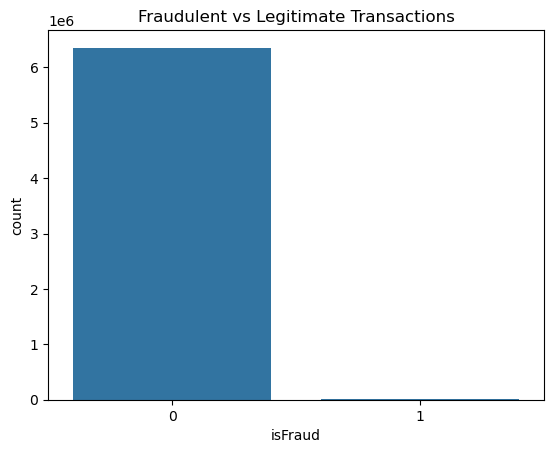

Percentage of fraudulent transactions: 0.1291%


In [85]:
# Plot a countplot to compare the number of fraudulent vs legitimate transactions, and print the percentage of fraud

sns.countplot(data=df, x='isFraud')
plt.title('Fraudulent vs Legitimate Transactions')
plt.show()

# Calculate and print the percentage of fraudulent transactions
fraud_percent = (df['isFraud'].sum() / len(df)) * 100
print(f"Percentage of fraudulent transactions: {fraud_percent:.4f}%")


In [87]:
# LabelEncoder to convert the 'type' column from categorical text to numeric labels
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

# Create a dictionary to map original transaction types to their encoded numeric values
type_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Transaction Type Mapping:", type_mapping)


Transaction Type Mapping: {'CASH_IN': 0, 'CASH_OUT': 1, 'DEBIT': 2, 'PAYMENT': 3, 'TRANSFER': 4}


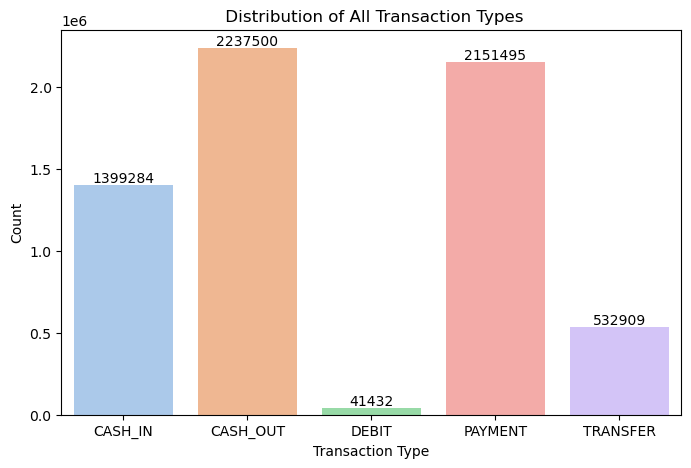

In [89]:
# Reverse mapping from encoded labels to original types
type_labels = {v: k for k, v in type_mapping.items()}

# Distribution of Transaction Types 
plt.figure(figsize=(8,5))
ax = sns.countplot(x='type', data=df, palette='pastel')
plt.title(' Distribution of All Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(ticks=list(type_labels.keys()), labels=list(type_labels.values()))

# Add count labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.show()



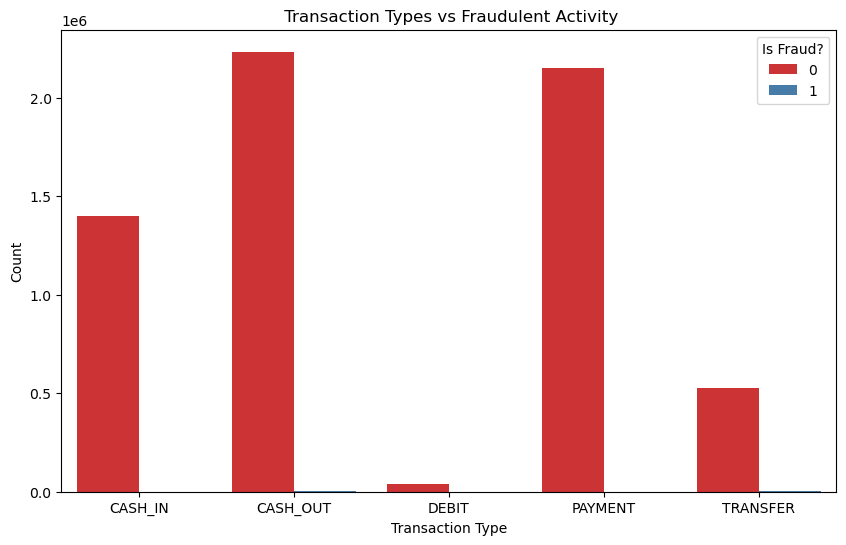

In [90]:
# Distribution of Transaction Types by Fraud Label
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='type', hue='isFraud', palette='Set1')
plt.title(' Transaction Types vs Fraudulent Activity')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(ticks=list(type_labels.keys()), labels=list(type_labels.values()))
plt.legend(title='Is Fraud?')
plt.show()

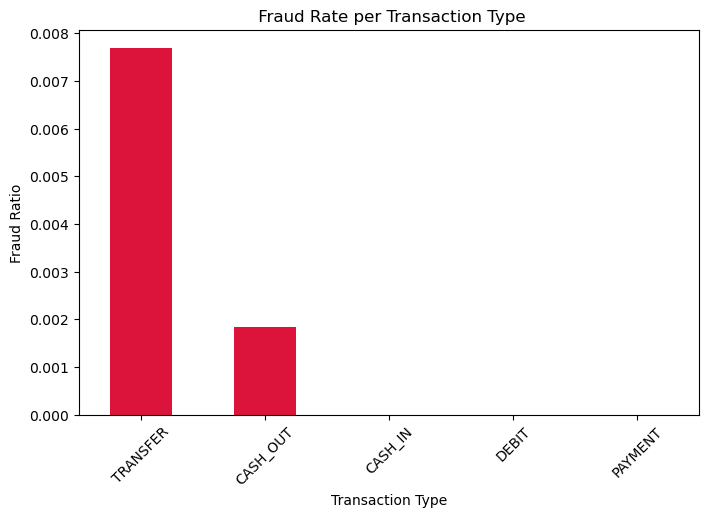

In [93]:
# Bar chart showing fraud ratio for each transaction type
fraud_ratio_per_type = df.groupby('type')['isFraud'].mean()
fraud_ratio_per_type.index = fraud_ratio_per_type.index.map(type_labels)

plt.figure(figsize=(8,5))
fraud_ratio_per_type.sort_values(ascending=False).plot(kind='bar', color='crimson')
plt.title(' Fraud Rate per Transaction Type')
plt.ylabel('Fraud Ratio')
plt.xlabel('Transaction Type')
plt.xticks(rotation=45)
plt.show()


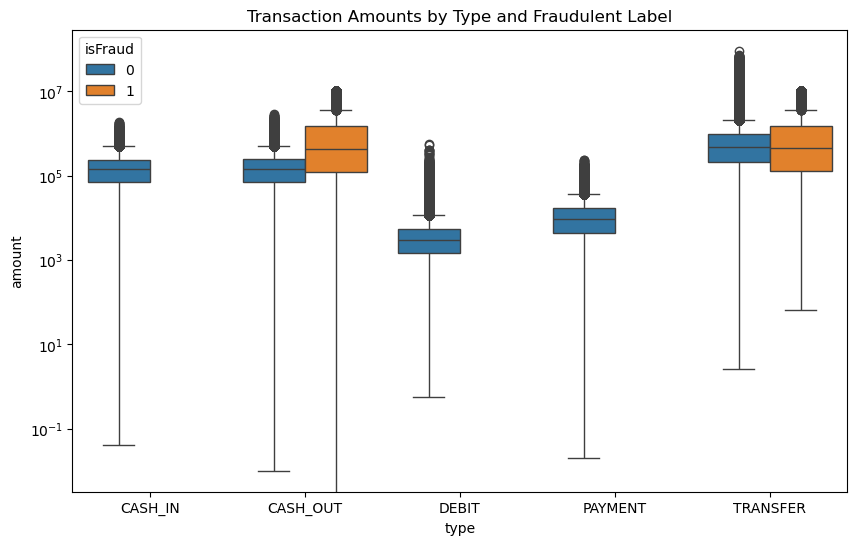

In [95]:
# Plot a boxplot to compare transaction amounts across types, highlighting the difference between fraudulent and legitimate transactions

plt.figure(figsize=(10,6))
sns.boxplot(x='type', y='amount', hue='isFraud', data=df)
plt.title('Transaction Amounts by Type and Fraudulent Label')
plt.xticks(ticks=list(type_labels.keys()), labels=list(type_labels.values()))
plt.yscale('log') 
plt.legend(title='isFraud')
plt.show()

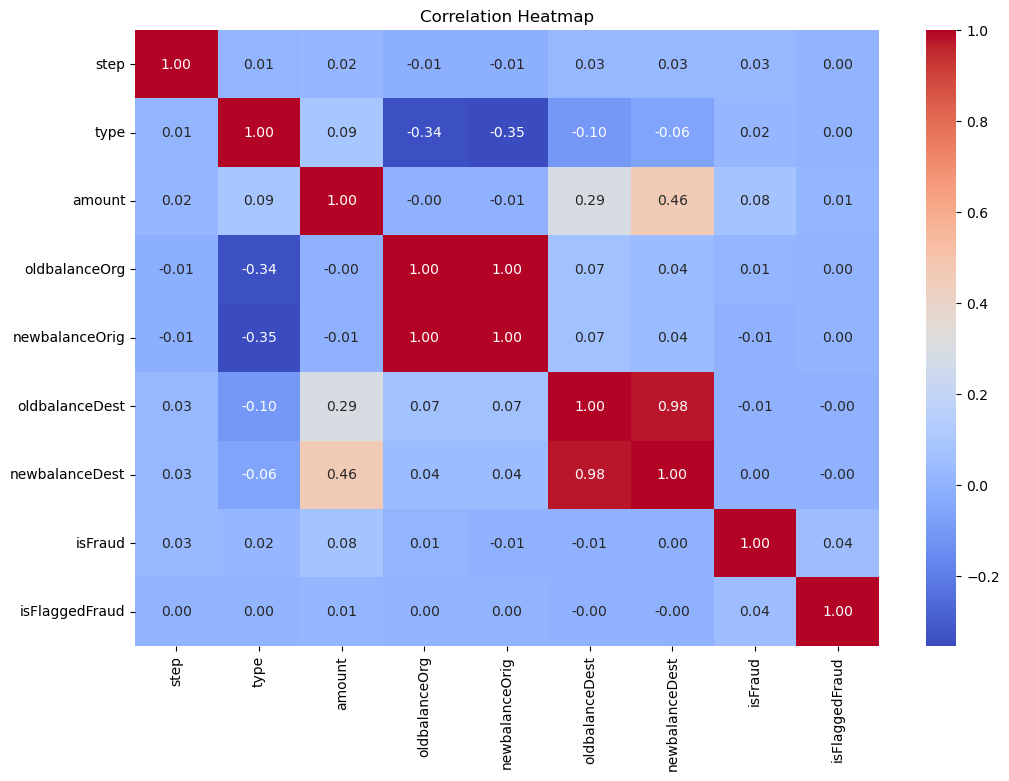

In [97]:
# Plot a heatmap to visualize the correlation between numerical features
df_corr = df.select_dtypes(include=['number'])
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# 🧠 Feature Engineering

In [100]:
def add_engineered_features(df):
    df = df.copy()
    df['diffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
    df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']
    return df


In [102]:
df = add_engineered_features(df)
print(df)

         step  type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0           1     3     9839.64  C1231006815      170136.00       160296.36   
1           1     3     1864.28  C1666544295       21249.00        19384.72   
2           1     4      181.00  C1305486145         181.00            0.00   
3           1     1      181.00   C840083671         181.00            0.00   
4           1     3    11668.14  C2048537720       41554.00        29885.86   
...       ...   ...         ...          ...            ...             ...   
6362615   743     1   339682.13   C786484425      339682.13            0.00   
6362616   743     4  6311409.28  C1529008245     6311409.28            0.00   
6362617   743     1  6311409.28  C1162922333     6311409.28            0.00   
6362618   743     4   850002.52  C1685995037      850002.52            0.00   
6362619   743     1   850002.52  C1280323807      850002.52            0.00   

            nameDest  oldbalanceDest  newbalanceDes

# Modeling Section

In [105]:
X=df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud','isFraud'], axis=1)
y = df['isFraud']


In [107]:
# Split data into training, validation, and testing sets (60% / 20% / 20%)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [109]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to generate synthetic minority samples (10% of the majority class)
sm = SMOTE(sampling_strategy=0.1, random_state=42)

# Resample the training set
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_res.value_counts())


Before SMOTE:
isFraud
0    3812644
1       4928
Name: count, dtype: int64

After SMOTE:
isFraud
0    3812644
1     381264
Name: count, dtype: int64


### 🚀 Model Training & Evaluation

Training Accuracy: 99.90%
Classification Report (Training):
              precision    recall  f1-score   support

           0     1.0000    0.9990    0.9995   3812644
           1     0.5675    0.9935    0.7223      4928

    accuracy                         0.9990   3817572
   macro avg     0.7837    0.9963    0.8609   3817572
weighted avg     0.9994    0.9990    0.9991   3817572



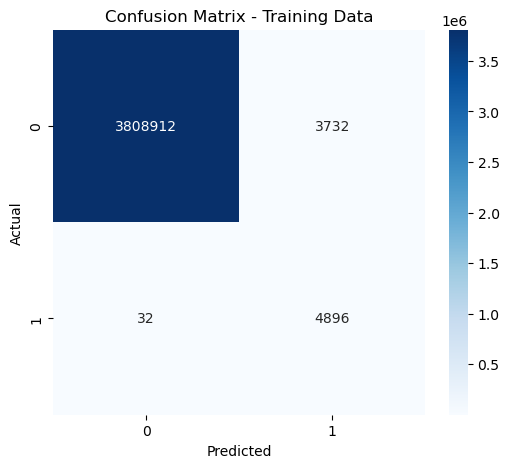

In [112]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)

y_train_pred = xgb.predict(X_train)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc:.2%}")

# Classification Report
print("Classification Report (Training):")
print(classification_report(y_train, y_train_pred, digits=4))

# Confusion Matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Training Data")
plt.show()


Validation Accuracy: 99.88%
Classification Report (Validation):
              precision    recall  f1-score   support

           0     1.0000    0.9989    0.9994   1270882
           1     0.5282    0.9805    0.6866      1642

    accuracy                         0.9988   1272524
   macro avg     0.7641    0.9897    0.8430   1272524
weighted avg     0.9994    0.9988    0.9990   1272524



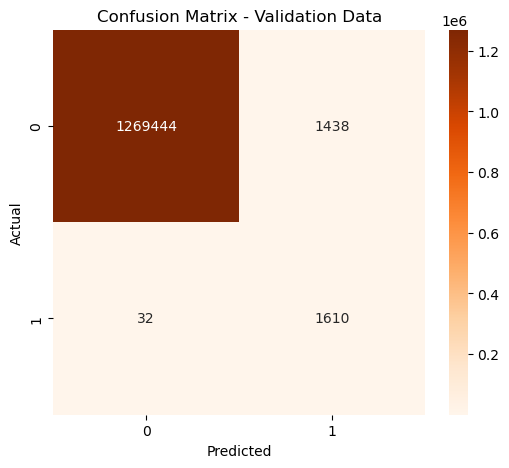

In [114]:
#Evaluate on validation data
y_val_pred = xgb.predict(X_val)

val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.2%}")

print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred, digits=4))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Data")
plt.show()


Test Accuracy: 99.89%
Classification Report (Test):
              precision    recall  f1-score   support

           0     1.0000    0.9989    0.9995   1270881
           1     0.5417    0.9805    0.6979      1643

    accuracy                         0.9989   1272524
   macro avg     0.7708    0.9897    0.8487   1272524
weighted avg     0.9994    0.9989    0.9991   1272524



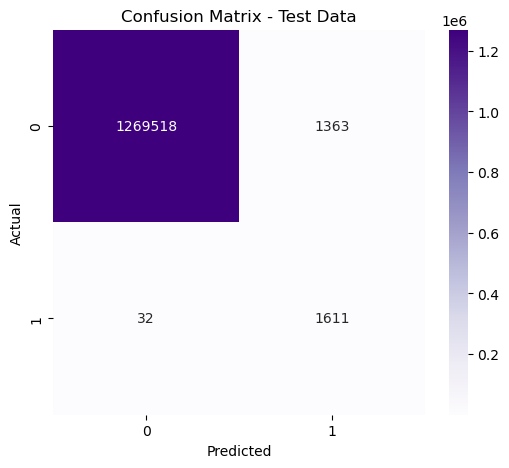

In [116]:
#Evaluate on test data
y_test_pred = xgb.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.2%}")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred, digits=4))
 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Data")
plt.show()


In [118]:
import joblib

joblib.dump(xgb, 'fraud_xgb_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("Saved: fraud_xgb_model.pkl and label_encoder.pkl")

Saved: fraud_xgb_model.pkl and label_encoder.pkl
